data sourses:
 - [Geoportal Berlin/ALKIS Berlin Gemeinde](https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_bezirk)
 - [Geoportal Berlin/Baumbestand Berlin - Straßenbäume](https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_baumbestand)
 - [Geoportal Berlin/Baumbestand Berlin - Anlagenbäume](https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_baumbestand_an)
 - [Geoportal Berlin/Alters- und Bestandesstruktur der Wälder - Forstbetriebskarte 2014 (Umweltatlas)](https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_05_04forst2014)
 
all under [dl-de/by-2-0](https://www.govdata.de/dl-de/by-2-0) license 


In [7]:
import os
import configparser

import fiona as fio
import glob
import math

import geopandas as gpd
from shapely.geometry import Point, Polygon

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#for legends
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D 


In [9]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

In [10]:
#getting the Berlin bounds
berlin_all = gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin','bezirke.gpkg'), crs ='EPSG:25833')
#_crs = "EPSG:32633" # ETRS89 / UTM zone 33N

berlin = gpd.GeoDataFrame({'geometry': berlin_all.unary_union,'index':[0]})
#get the bounds
total_bounds = berlin.total_bounds
# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

In [12]:
# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size (in meters)
square_size = 1000

while y <= maxY:
    while x <= maxX:
        geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry'])

#crop fishnet to the shapefile
fishnet = gpd.sjoin(fishnet, berlin, how='inner').reset_index(drop=True).set_crs('EPSG:25833')
fishnet = fishnet.drop(columns=["index", "index_right"])
fishnet.to_file(os.path.join(gdata_root,'fishnets', 'berlin-1000-1000.geojson'))

(367700.8250000002, 418300.8250000002, 5797620.66, 5839420.66)

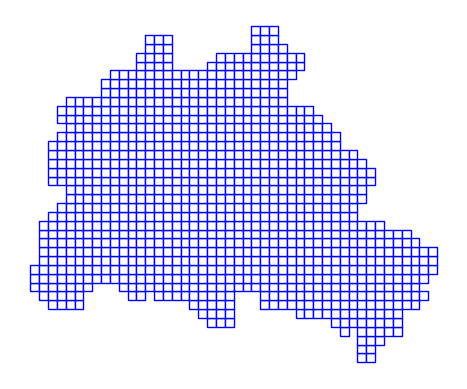

In [13]:
grid=fishnet.copy()
ax = grid.plot(color="white", edgecolor="blue")
ax.axis("off")

In [14]:
#read the tree files
trees_an = gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin','baumbestand_an.gpkg'), crs ='EPSG:25833')
trees_str = gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin','baumbestand_str.gpkg'), crs ='EPSG:25833')
gdf=pd.concat([trees_an,trees_str],ignore_index=True)

In [15]:
#explore a bit...
gdf.head()

,baumid,standortnr,kennzeich,namenr,art_dtsch,art_bot,gattung_deutsch,gattung,pflanzjahr,standalter,kronedurch,stammumfg,baumhoehe,bezirk,eigentuemer,geometry,strname,hausnr,zusatz
0,00008100:000be4d0,066,411.232,Weigandufer,Eingriffliger Weissdorn,Crataegus monogyna,WEIßDORN,CRATAEGUS,1989,34.0,NaN,60.0,NaN,Neukölln,Land Berlin,POINT (394621.783 5815731.410),NaN,NaN,NaN
1,00008100:000be4d2,059,411.232,Weigandufer,Hahnensporn-Weissdorn,Crataegus crus-galli,WEIßDORN,CRATAEGUS,1994,29.0,NaN,37.0,NaN,Neukölln,Land Berlin,POINT (394660.283 5815777.205),NaN,NaN,NaN
2,00008100:000be4f2,062,411.232,Weigandufer,Pflaumenblättriger Weiss-Dorn,Crataegus prunifolia,WEIßDORN,CRATAEGUS,1987,36.0,NaN,65.0,NaN,Neukölln,Land Berlin,POINT (394643.319 5815756.320),NaN,NaN,NaN
3,00008100:000bf296,14,221.068,Roetepfuhl-Grünanlage,Gemeine Rosskastanie,Aesculus hippocastanum,ROSSKASTANIE,AESCULUS,1985,38.0,NaN,128.0,NaN,Neukölln,Land Berlin,POINT (393199.923 5811316.447),NaN,NaN,NaN
4,00008100:000bf297,13,221.068,Roetepfuhl-Grünanlage,Gemeine Rosskastanie,Aesculus hippocastanum,ROSSKASTANIE,AESCULUS,1985,38.0,NaN,112.0,NaN,Neukölln,Land Berlin,POINT (393205.164 5811322.008),NaN,NaN,NaN


In [16]:
pivot = gdf.groupby(["gattung_deutsch", "bezirk" ])["baumid"].count().unstack()
pivot = pivot.transpose()
pivot["Majority"] = pivot.idxmax(axis=1)
pivot

gattung_deutsch,AHORN,AMBERBAUM,APFEL,BIRKE,BIRNE,BLASENESCHE,BLAUREGEN,BUCHE,BUCHSBAUM,DOUGLASIE,...,WEIDE,WEIHRAUCHZEDER,WEIßDORN,ZAUBERNUSS,ZEDER,ZELKOVE,ZYPRESSE,ZÜRGELBAUM,ÖLWEIDE,Majority
bezirk,,,,,,,,,,,,,,,,,,,,,
Charlottenburg-Wilmersdorf,12941.0,41.0,185.0,1684.0,53.0,8.0,NaN,842.0,NaN,736.0,...,316.0,NaN,756.0,NaN,2.0,NaN,NaN,53.0,2.0,LINDE
Friedrichshain-Kreuzberg,8976.0,68.0,189.0,581.0,472.0,1.0,NaN,148.0,NaN,32.0,...,395.0,NaN,973.0,NaN,3.0,NaN,NaN,30.0,14.0,LINDE
Lichtenberg,13929.0,89.0,1128.0,1403.0,562.0,9.0,NaN,245.0,NaN,165.0,...,879.0,1.0,430.0,NaN,11.0,1.0,NaN,20.0,51.0,AHORN
Marzahn-Hellersdorf,15088.0,72.0,699.0,3559.0,140.0,4.0,1.0,348.0,1.0,77.0,...,1853.0,NaN,600.0,1.0,4.0,1.0,NaN,17.0,72.0,AHORN
Mitte,15349.0,113.0,181.0,1693.0,359.0,21.0,NaN,2805.0,NaN,111.0,...,258.0,NaN,470.0,NaN,4.0,7.0,NaN,41.0,11.0,AHORN
Neukölln,11498.0,86.0,424.0,1106.0,88.0,NaN,NaN,1226.0,1.0,607.0,...,577.0,NaN,658.0,NaN,2.0,1.0,2.0,1.0,1.0,LINDE
Pankow,22573.0,109.0,651.0,3500.0,530.0,20.0,NaN,824.0,3.0,174.0,...,1748.0,NaN,1166.0,NaN,33.0,NaN,2.0,3.0,39.0,AHORN
Reinickendorf,16808.0,44.0,124.0,3119.0,64.0,NaN,NaN,1306.0,NaN,1070.0,...,345.0,NaN,614.0,1.0,10.0,1.0,NaN,NaN,12.0,AHORN
Spandau,8969.0,28.0,346.0,3077.0,300.0,NaN,NaN,429.0,NaN,602.0,...,814.0,1.0,538.0,NaN,2.0,NaN,NaN,NaN,4.0,EICHE


In [17]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 733636 entries, 0 to 733635
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   baumid           733636 non-null  object  
 1   standortnr       733634 non-null  object  
 2   kennzeich        733636 non-null  object  
 3   namenr           733636 non-null  object  
 4   art_dtsch        732736 non-null  object  
 5   art_bot          732737 non-null  object  
 6   gattung_deutsch  709729 non-null  object  
 7   gattung          732736 non-null  object  
 8   pflanzjahr       591718 non-null  object  
 9   standalter       591732 non-null  float64 
 10  kronedurch       405626 non-null  float64 
 11  stammumfg        729541 non-null  float64 
 12  baumhoehe        587642 non-null  float64 
 13  bezirk           733636 non-null  object  
 14  eigentuemer      733636 non-null  object  
 15  geometry         733636 non-null  geometry
 16  strname     

In [18]:
gdf.isna().sum()

baumid                  0
standortnr              2
kennzeich               0
namenr                  0
art_dtsch             900
art_bot               899
gattung_deutsch     23907
gattung               900
pflanzjahr         141918
standalter         141904
kronedurch         328010
stammumfg            4095
baumhoehe          145994
bezirk                  0
eigentuemer             0
geometry                0
strname            417361
hausnr             529362
zusatz             700315
dtype: int64

In [19]:
#merge grid cell index to trees
merged = gpd.sjoin(gdf, grid, how='left')

In [20]:
# count tree types by grid cell and get the most frequent type
tree_type = merged.groupby(["index_right", "gattung"])["baumid"].count().to_frame().unstack()
tree_type.columns = tree_type.columns.droplevel(level=0)
tree_type["Majority_tree"] = tree_type.idxmax(axis=1)
for i in range(len(tree_type)):
    tree_type.loc[tree_type.index[i], "Majority_tree_number"] = tree_type.iloc[i][tree_type.iloc[i]["Majority_tree"]]
tree_type["Tree_total"] =  tree_type[tree_type.columns[:-2]].sum(axis=1)
tree_type["Majority_tree_perc"] = tree_type["Majority_tree_number"] / tree_type["Tree_total"] *100

tree_type

gattung,ACER,AESCULUS,AILANTHUS,ALNUS,AMELANCHIER,Abies,BETULA,BIOTA,BUXUS,CALOCEDRUS,...,TROCHODENDRON,TSUGA,ULMUS,UNBEKANNT,WISTERIA,ZELKOVA,Majority_tree,Majority_tree_number,Tree_total,Majority_tree_perc
index_right,,,,,,,,,,,,,,,,,,,,,
13.0,3.0,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,PINUS,38.0,117.0,32.478632
14.0,106.0,40.0,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TILIA,184.0,500.0,36.800000
15.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TILIA,80.0,86.0,93.023256
19.0,5.0,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,TILIA,7.0,35.0,20.000000
20.0,7.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ACER,7.0,23.0,30.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999.0,56.0,6.0,NaN,12.0,NaN,2.0,17.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,QUERCUS,57.0,269.0,21.189591
1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TILIA,5.0,7.0,71.428571
1002.0,63.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,QUERCUS,228.0,324.0,70.370370


In [21]:
# include tree counts and type in grid
grid.loc[tree_type.index, "total_trees"] = tree_type["Tree_total"].values
grid.loc[tree_type.index, "majority_tree"] = tree_type["Majority_tree"].values
grid.loc[tree_type.index, "majority_tree_perc"] = tree_type["Majority_tree_perc"].values

In [23]:
#create new column to combine tree type
type_map = {'TILIA':"Lime", 'ACER':'Maple', 'QUERCUS':"Oak", 'PINUS':"Pine", 'BETULA':"Birch", 'POPULUS':"Populus", 'FRAXINUS':"Ash",
       'PLATANUS':"Plane", 'ROBINIA':"Robinia", 'AESCULUS':"Other", 'SALIX':"Other", 'CARPINUS':"Other", 'ALNUS':"Other", 'MALUS':"Other",
       'FAGUS':"Other", 'PSEUDOTSUGA':"Other", 'UNBEKANNT':"Other", 'ULMUS':"Other" , 'SORBUS':"Other" , 'GLEDITSIA':"Other" , 'PRUNUS':"Other"  }

grid["majority_tree_collapsed"] = grid["majority_tree"].map(type_map)

In [24]:
grid["majority_tree_collapsed"].value_counts()

majority_tree_collapsed
Lime       306
Maple      279
Oak        112
Other       40
Pine        20
Birch       19
Populus     16
Ash         12
Plane       11
Robinia     10
Name: count, dtype: int64

In [28]:
# map symbols against tree types
symbol_map = {'Other':"", 'Lime': "s", 'Maple':"*", 'Oak':"h", 'Pine':"D",'Birch':".",'Populus':"d",'Ash':"p",'Plane':"P",'Robinia':">" }
grid["majority_tree_symbol"] = grid["majority_tree_collapsed"].map(symbol_map)
grid["majority_tree_symbol"] = grid["majority_tree_symbol"].fillna("")

grid_centroid = grid.copy()
grid_centroid["geometry"] = grid_centroid["geometry"].centroid


C:\temp\ipykernel_12720\504353330.py:16: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(grid_centroid["geometry"].x.iloc[i], grid_centroid["geometry"].y.iloc[i],


Text(0.1, 1.1, 'Prevailing tree')

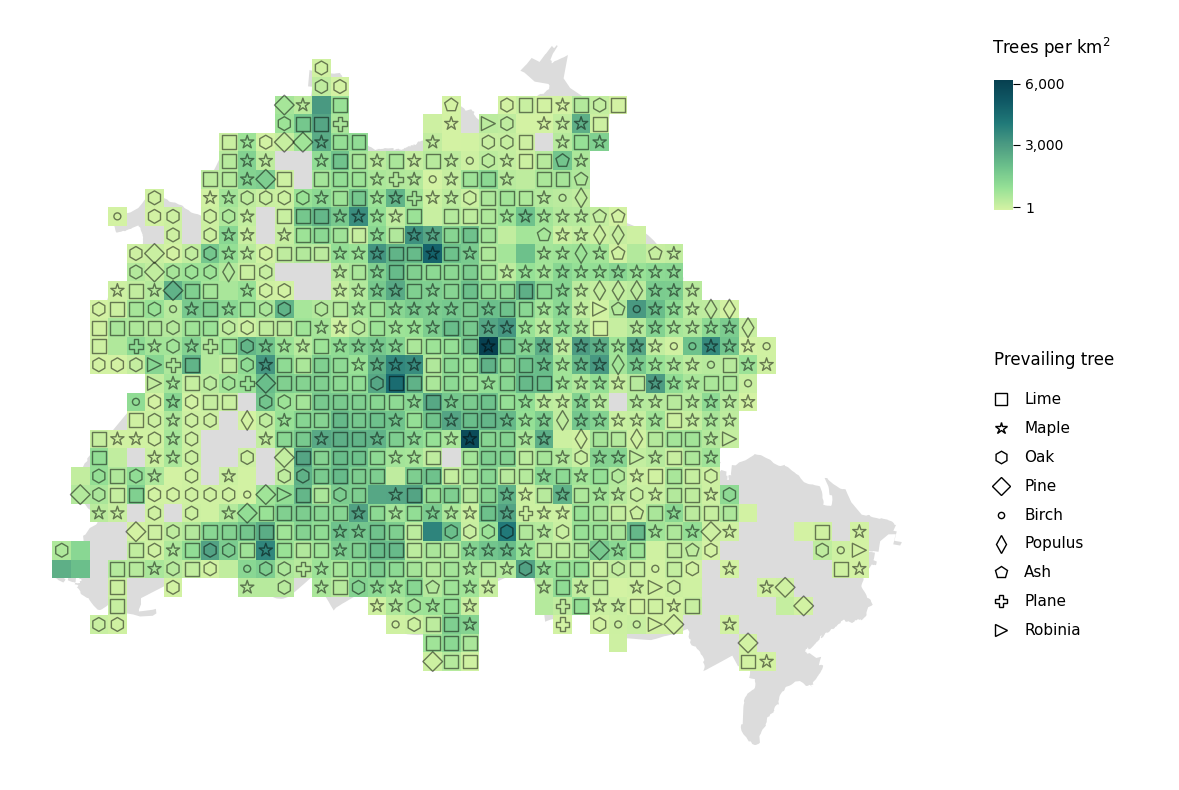

In [29]:
#configuration, colors and fonts
from palettable.cartocolors.sequential import BluGrn_7, Emrld_7, agGrnYl_7_r
cmap = Emrld_7.mpl_colormap
#bg_color = "#EFEFEF"
bg_color = "white"

#plot
fig, ax = plt.subplots(figsize=(13, 10))
fig.set_facecolor(bg_color)

# ===
# Data
values = "total_trees"
grid.plot(ax=ax, column=values, alpha=1, zorder=3, cmap=cmap)
for i in range(len(grid_centroid)):
    ax.scatter(grid_centroid["geometry"].x.iloc[i], grid_centroid["geometry"].y.iloc[i],
               s=100, marker=grid_centroid["majority_tree_symbol"].iloc[i] , edgecolor="black", linewidth=1, facecolors="None", zorder=4, alpha=0.5)
             #  s=200, marker=svg_marker , color="black", zorder=4, alpha=0.5)
#grid.plot(ax=ax, color="#DCDCDC",zorder=2)
berlin.plot(ax=ax, color="#DCDCDC",zorder=2 )
ax.axis("off")



## Legend for colormap
lgd1 = fig.add_axes([0.91, 0.68, 0.015, 0.13]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=lgd1, anchor=(1,1.2), orientation='vertical', drawedges=False, ticks=[0.02,0.5, 0.97])
_max = math.ceil(grid[values].max() / 1000.0) * 1000
cb.set_ticklabels(["1", "{:,}".format(int(_max/2)), "{:,}".format(_max)])
cb.outline.set_visible(False)
lgd1.tick_params(size=5)
lgd1.text(-0.1, 1.2, r"Trees per km$^2$", ha="left", size=12)

## Legend for shapes
lgd2 = fig.add_axes([0.895, 0.25, 0.15, 0.25]) 
kw = dict(color="None" , markerfacecolor="None", markeredgecolor="black", markersize=9, alpha=1,)
legend_elements2 = [Line2D([0], [0], marker='s' , label="Lime", **kw), 
                  Line2D([0], [0], marker="*" , label="Maple", **kw),
                  Line2D([0], [0], marker='h' , label="Oak",**kw),
                  Line2D([0], [0], marker='D' , label="Pine", **kw),
                  Line2D([0], [0], marker='.' , label="Birch",  **kw),
                  Line2D([0], [0], marker='d' , label="Populus",  **kw),
                  Line2D([0], [0], marker='p' , label="Ash",  **kw),
                  Line2D([0], [0], marker='P' , label="Plane",  **kw),
                  Line2D([0], [0], marker='>' , label="Robinia",  **kw),
                  ]
L = lgd2.legend(frameon=False, handles=legend_elements2, loc='center left', ncol=1, handletextpad=0.7, labelspacing=1)
plt.setp(L.texts,  va="baseline",color="black", size=11, )    
lgd2.axis('off')
lgd2.text(0.1, 1.1, r"Prevailing tree", ha="left", size=12 )

That is nice, but some large areas of the city are not covered -> need to look into forests data

In [30]:
forests = gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin','Alters- und Bestandesstruktur der Wälder.gpkg'), crs ='EPSG:25833')

(308064.58128000033, 429431.8431200004, 5768559.137499999, 5864153.9445)

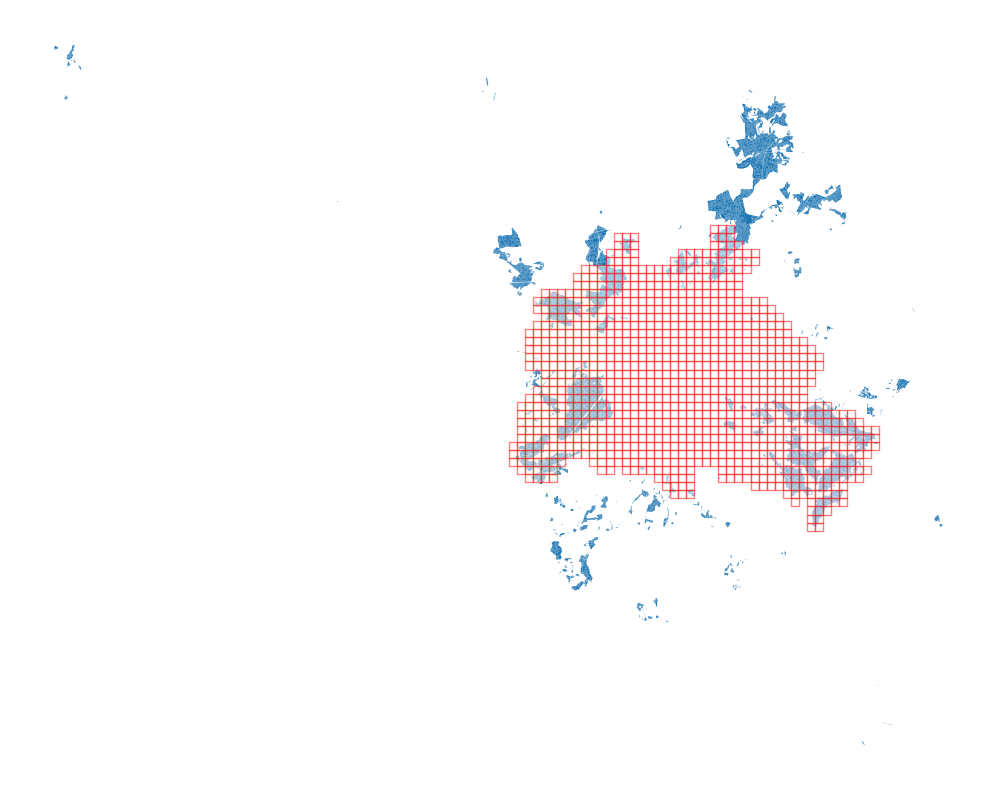

In [84]:
fig, ax = plt.subplots(figsize=(13, 10))
fig.set_facecolor(bg_color)
forests.plot(ax=ax)
fishnet.plot(ax=ax,color="white", edgecolor="red",alpha=.5)
ax.axis("off")

In [79]:
#discard forests outside city borders
forests_within_city_borders = gpd.overlay(forests, berlin.set_crs('EPSG:25833'), how = 'intersection',keep_geom_type=True)
#now only consider forests in the grid cells with no city trees (as we cannot directly compare density)
forests_wo_city_trees = gpd.overlay(forests_within_city_borders, fishnet[grid.total_trees.isna()], how = 'intersection')
forests_wo_city_trees.plot()
#select only those grid cells that contain forests
fishnet_forest_only = gpd.GeoDataFrame(geometry=gpd.sjoin(fishnet,forests_wo_city_trees,how = 'inner',predicate='contains').geometry.unique(), crs ='EPSG:25833')

In [80]:
#calculate what type of tree uses the most space within each grid cell in for forests
def get_prevailing_tree(row):
    gdf = forests_wo_city_trees[forests_wo_city_trees.within(row.geometry)]
    trees = pd.concat([pd.DataFrame({'tree':gdf['s1_1_deuts'],'area':gdf['geometry'].area*gdf['s1_1_misch']/100}),
                   pd.DataFrame({'tree':gdf['s1_2_deuts'],'area':gdf['geometry'].area*gdf['s1_2_misch']/100}),
                   pd.DataFrame({'tree':gdf['s1_3_deuts'],'area':gdf['geometry'].area*gdf['s1_3_misch']/100}),
                   pd.DataFrame({'tree':gdf['s1_4_deuts'],'area':gdf['geometry'].area*gdf['s1_4_misch']/100}),
                   pd.DataFrame({'tree':gdf['s1_5_deuts'],'area':gdf['geometry'].area*gdf['s1_5_misch']/100})],
                   ignore_index=True)
    try:
        return trees.dropna().groupby('tree')['area'].sum().idxmax()
    except:
        return pd.NA

fishnet_forest_only['tree'] = fishnet_forest_only.apply(get_prevailing_tree,axis=1)
fishnet_forest_only.tree.value_counts()    

tree
Gemeine Kiefer            123
Eiche                       7
Balsampappel                6
Stieleiche                  3
Roterle                     3
Gemeine Birke               2
Eschenblättriger Ahorn      2
Rotbuche                    1
Traubeneiche                1
Gemeine Esche               1
Blöße                       1
Aspe                        1
Name: count, dtype: int64

In [37]:
#repeat the mapping
type_map_forest = {'Gemeine Kiefer':"Pine", 'Eiche':'Oak', 'Balsampappel':"Populus", 'Stieleiche':"Oak", 'Roterle':"Other", 'Gemeine Birke':"Birch", 'Eschenblättriger Ahorn':"Maple",
       'Rotbuche':"Other", 'Traubeneiche':"Oak", 'Gemeine Esche':"Ash", 'Blöße':"Other", 'Aspe':"Populus"  }

fishnet_forest_only["majority_tree_collapsed"] = fishnet_forest_only["tree"].map(type_map_forest)

fishnet_forest_only["majority_tree_symbol"] = fishnet_forest_only["majority_tree_collapsed"].map(symbol_map)
fishnet_forest_only["majority_tree_symbol"] = fishnet_forest_only["majority_tree_symbol"].fillna("")

fishnet_forest_only_centroid = fishnet_forest_only.copy()
fishnet_forest_only_centroid["geometry"] = fishnet_forest_only["geometry"].centroid

(368178.9791885, 418158.2974015, 5798028.337793499, 5839226.348416501)

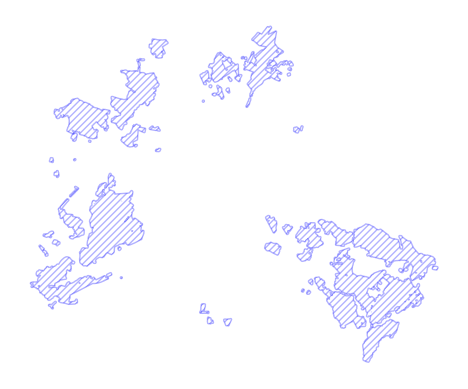

In [88]:
#now merge nearby forest polygons to create larger uinterrupted areas
forest_polygons=forests_within_city_borders.copy()
forest_polygons=forest_polygons.geometry.buffer(50).unary_union.buffer(50)
forest_polygons=gpd.GeoSeries(forest_polygons)

ax=forest_polygons.plot(hatch="/////",edgecolor='blue',color="None",alpha=0.3)
ax.axis("off")

C:\temp\ipykernel_12720\3733930103.py:18: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(grid_centroid["geometry"].x.iloc[i], grid_centroid["geometry"].y.iloc[i],
C:\temp\ipykernel_12720\3733930103.py:23: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(fishnet_forest_only_centroid["geometry"].x.iloc[i], fishnet_forest_only_centroid["geometry"].y.iloc[i],


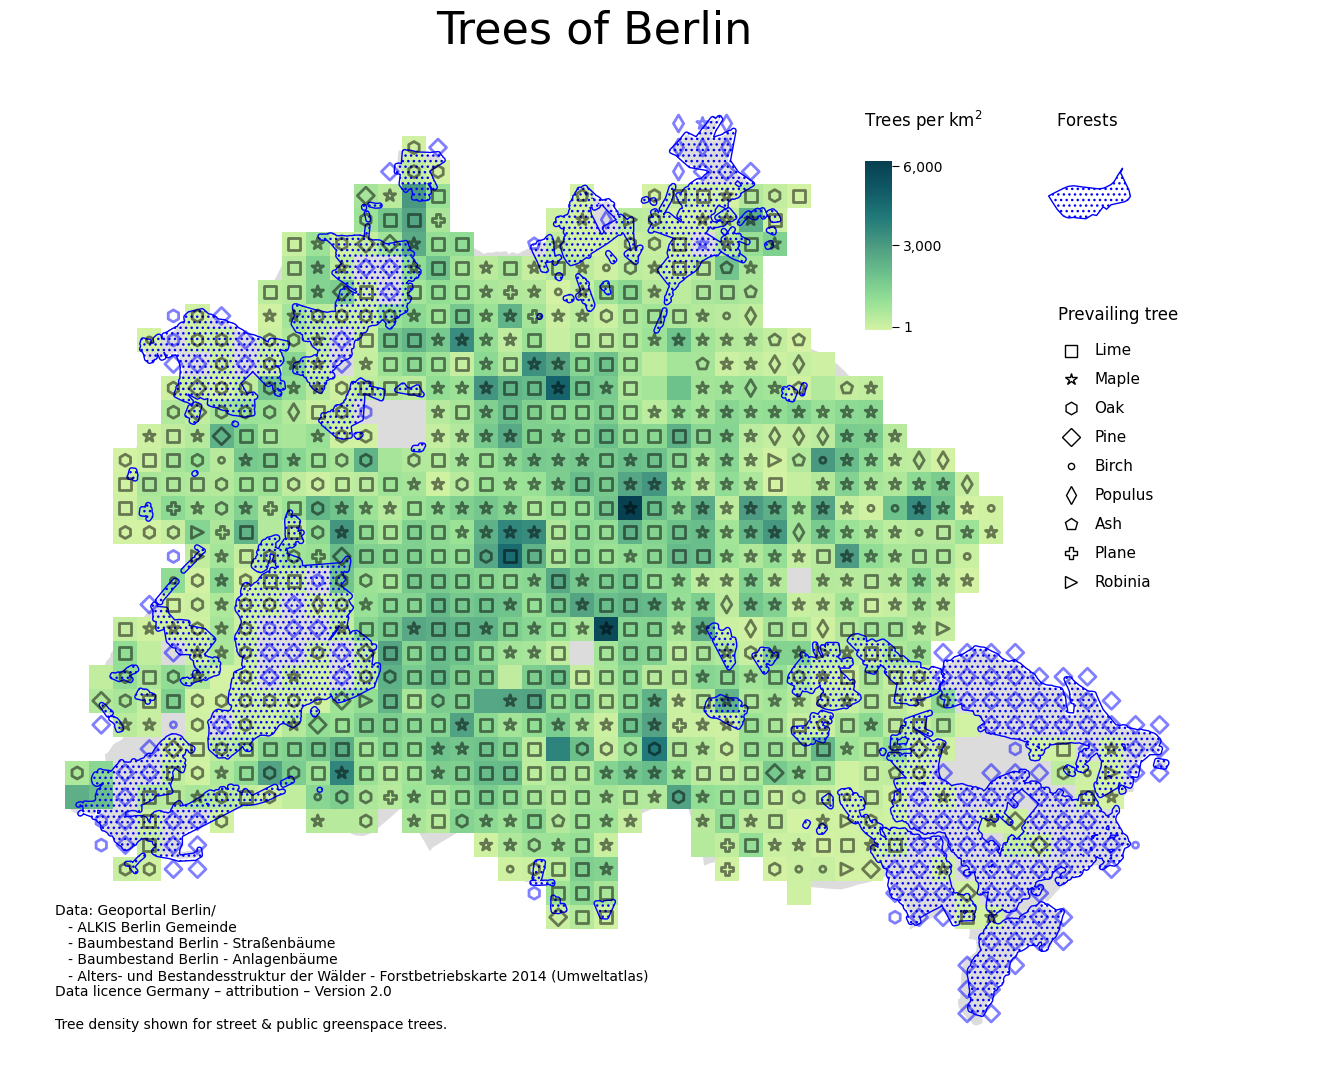

In [93]:
#finally combine city trees and forest
#configuration, colors and fonts
from palettable.cartocolors.sequential import BluGrn_7, Emrld_7, agGrnYl_7_r
cmap = Emrld_7.mpl_colormap
#bg_color = "#EFEFEF"
bg_color = "white"

#plot
fig, ax = plt.subplots(figsize=(18, 13))
fig.set_facecolor(bg_color)

# ===
# Data
values = "total_trees"
grid.plot(ax=ax, column=values, alpha=1, zorder=3, cmap=cmap)
a.plot(ax=ax,hatch="...",edgecolor='blue',color="None",alpha=1,zorder=3)
for i in range(len(grid_centroid)):
    ax.scatter(grid_centroid["geometry"].x.iloc[i], grid_centroid["geometry"].y.iloc[i],
               s=75, marker=grid_centroid["majority_tree_symbol"].iloc[i] , edgecolor="black", linewidth=2, facecolors="None", zorder=4, alpha=0.5)
             #  s=200, marker=svg_marker , color="black", zorder=4, alpha=0.5)
        
for i in range(len(fishnet_forest_only_centroid)):
    ax.scatter(fishnet_forest_only_centroid["geometry"].x.iloc[i], fishnet_forest_only_centroid["geometry"].y.iloc[i],
               s=75, marker=fishnet_forest_only_centroid["majority_tree_symbol"].iloc[i] , edgecolor="blue", linewidth=2, facecolors="None", zorder=4, alpha=0.5)
             #  s=200, marker=svg_marker , color="black", zorder=4, alpha=0.5)        
#grid.plot(ax=ax, color="#DCDCDC",zorder=2)
berlin.plot(ax=ax, color="#DCDCDC",zorder=2 )
ax.axis("off")



## Legend for colormap
lgd1 = fig.add_axes([0.65, 0.68, 0.015, 0.13]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=lgd1, anchor=(1,1.2), orientation='vertical', drawedges=False, ticks=[0.02,0.5, 0.97])
_max = math.ceil(grid[values].max() / 1000.0) * 1000
cb.set_ticklabels(["1", "{:,}".format(int(_max/2)), "{:,}".format(_max)])
cb.outline.set_visible(False)
lgd1.tick_params(size=5)  
lgd1.text(-0.03, 1.2, r"Trees per km$^2$              Forests", ha="left", size=12)


lgd2 = fig.add_axes([0.75, 0.76, 0.05, 0.05])  
forests_within_city_borders.loc[[0],'geometry'].plot(ax = lgd2, hatch="...",edgecolor='blue',color="None",alpha=1)
#lgd2.text(0.85, 0.95, 'Forests', ha="left", size=12, transform=ax.transAxes)
lgd2.axis('off')


## Legend for shapes
lgd3 = fig.add_axes([0.75, 0.45, 0.15, 0.25]) 
kw = dict(color="None" , markerfacecolor="None", markeredgecolor="black", markersize=9, alpha=1,)
legend_elements3 = [Line2D([0], [0], marker='s' , label="Lime", **kw), 
                  Line2D([0], [0], marker="*" , label="Maple", **kw),
                  Line2D([0], [0], marker='h' , label="Oak",**kw),
                  Line2D([0], [0], marker='D' , label="Pine", **kw),
                  Line2D([0], [0], marker='.' , label="Birch",  **kw),
                  Line2D([0], [0], marker='d' , label="Populus",  **kw),
                  Line2D([0], [0], marker='p' , label="Ash",  **kw),
                  Line2D([0], [0], marker='P' , label="Plane",  **kw),
                  Line2D([0], [0], marker='>' , label="Robinia",  **kw),
                  ]
L = lgd3.legend(frameon=False, handles=legend_elements2, loc='center left', ncol=1, handletextpad=0.7, labelspacing=1)
plt.setp(L.texts,  va="baseline",color="black", size=11, )    
lgd3.axis('off')
lgd3.text(0.05, 0.95, r"Prevailing tree", ha="left", size=12 )

# ===
#title
plt.figtext(0.5, 0.9 , "Trees of Berlin", fontsize=32,  ha="center", color="black")
plt.figtext(0.2, 0.13 , r'''
Data: Geoportal Berlin/
   - ALKIS Berlin Gemeinde
   - Baumbestand Berlin - Straßenbäume
   - Baumbestand Berlin - Anlagenbäume
   - Alters- und Bestandesstruktur der Wälder - Forstbetriebskarte 2014 (Umweltatlas)
Data licence Germany – attribution – Version 2.0

Tree density shown for street & public greenspace trees.
''', fontsize=10,  ha="left", color="black")

plt.savefig("Berlin_trees.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)
